In [8]:
# Cell 1 — Environment + Path check (run this first)
import os, math, random
from pathlib import Path
import sys
import numpy as np
import pandas as pd
from PIL import Image

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED)

# Dataset roots (raw strings for Windows paths with spaces)
DATA_DIR = Path(r"H:\My Drive\A Multimodal Generative AI System for Skin Lesion Diagnosis and Explanation\data")
IMG_DIR  = DATA_DIR / "images" / "train"
GT_CSV   = DATA_DIR / "ISIC_2020_Training_GroundTruth.csv"
META_CSV = DATA_DIR / "ISIC_2020_Training_Metadata_v2.csv"

print("Python:", sys.version)
print("Pandas:", pd.__version__)
print("NumPy :", np.__version__)
print("Pillow:", Image.__version__)

print("\nExists — IMG_DIR:", IMG_DIR.exists())
print("Exists — GT_CSV :", GT_CSV.exists())
print("Exists — META_CSV:", META_CSV.exists())

# Optional: show a small sample of files
if IMG_DIR.exists():
    sample_files = list(IMG_DIR.glob("*.jpg"))[:3]
    print("\nSample image files:", [p.name for p in sample_files])


Python: 3.13.7 (tags/v3.13.7:bcee1c3, Aug 14 2025, 14:15:11) [MSC v.1944 64 bit (AMD64)]
Pandas: 2.3.2
NumPy : 2.3.2
Pillow: 11.3.0

Exists — IMG_DIR: True
Exists — GT_CSV : True
Exists — META_CSV: True

Sample image files: ['ISIC_0190725.jpg', 'ISIC_0196403.jpg', 'ISIC_0200921.jpg']


In [9]:
import pandas as pd
from pathlib import Path
import os

# Reuse paths from Cell 1: DATA_DIR, IMG_DIR, GT_CSV, META_CSV

# Read CSVs
gt   = pd.read_csv(GT_CSV)   # ISIC_2020_Training_GroundTruth.csv
meta = pd.read_csv(META_CSV) # ISIC_2020_Training_Metadata_v2.csv

# Merge on image_name (present in both CSVs)
df = gt.merge(meta, on="image_name", how="left")

# Build absolute .jpg paths for each image
img_root = Path(IMG_DIR).resolve()
df["image_path"] = df["image_name"].astype(str).apply(lambda x: str((img_root / f"{x}.jpg").resolve()))

# Verify existence of files
df["exists"] = df["image_path"].apply(os.path.exists)

# Basic sanity checks
total = len(df)
missing = (~df["exists"]).sum()
print(f"Rows: {total} | Missing image files: {missing}")
print("Columns:", list(df.columns)[:12], "...")

# Peek at a few rows
df.head(3)


Rows: 33126 | Missing image files: 0
Columns: ['image_name', 'patient_id_x', 'sex_x', 'age_approx_x', 'anatom_site_general_challenge_x', 'diagnosis_x', 'benign_malignant_x', 'target_x', 'patient_id_y', 'lesion_id', 'sex_y', 'age_approx_y'] ...


,image_name,patient_id_x,sex_x,age_approx_x,anatom_site_general_challenge_x,diagnosis_x,benign_malignant_x,target_x,patient_id_y,lesion_id,sex_y,age_approx_y,anatom_site_general_challenge_y,diagnosis_y,benign_malignant_y,target_y,image_path,exists
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,IP_7279968,IL_7972535,male,45.0,head/neck,unknown,benign,0,H:\My Drive\A Multimodal Generative AI System ...,True
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,IP_3075186,IL_4649854,female,45.0,upper extremity,unknown,benign,0,H:\My Drive\A Multimodal Generative AI System ...,True
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,IP_2842074,IL_9087444,female,50.0,lower extremity,nevus,benign,0,H:\My Drive\A Multimodal Generative AI System ...,True


Columns (first 30): ['age_approx_x', 'age_approx_y', 'anatom_site_general_challenge_x', 'anatom_site_general_challenge_y', 'benign_malignant_x', 'benign_malignant_y', 'diagnosis_x', 'diagnosis_y', 'exists', 'image_name', 'image_path', 'lesion_id', 'patient_id_x', 'patient_id_y', 'sex_x', 'sex_y', 'target_x', 'target_y']


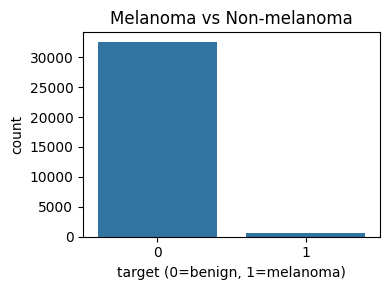

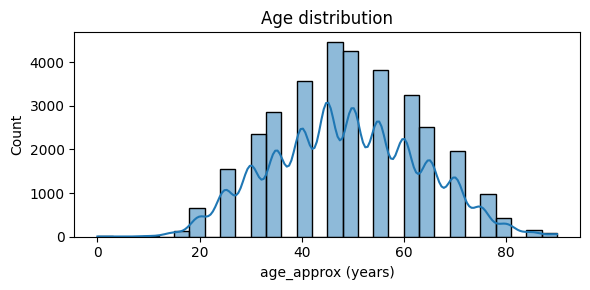

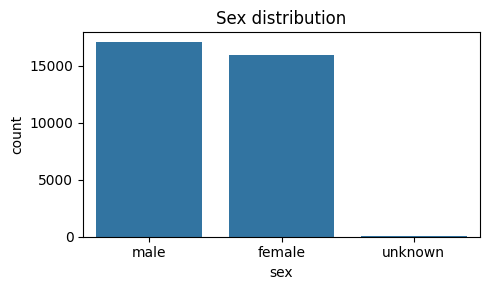

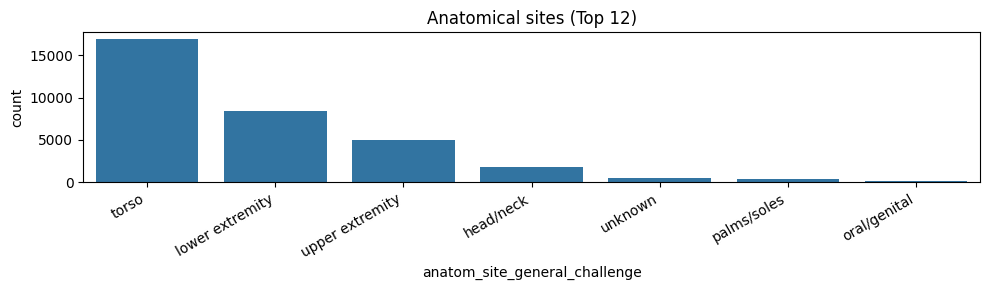

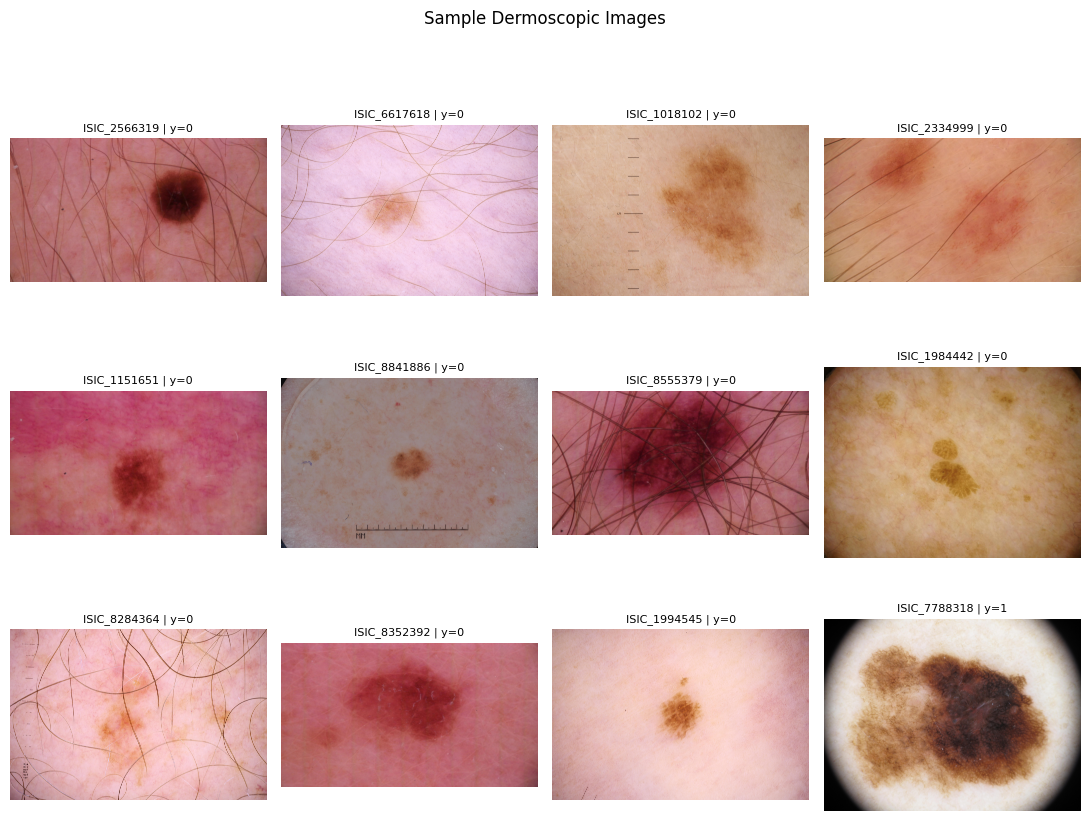

Target counts:
 target
0    32542
1      584
Name: count, dtype: int64


In [14]:
# Cell 3 (revised) — canonicalize columns, build `target`, then EDA plots

import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

assert "df" in globals(), "DataFrame `df` not found. Run the merge cell first."

# 0) Inspect columns once
print("Columns (first 30):", sorted(df.columns)[:30])

# 1) Canonicalize duplicated columns from merge (_x from ground truth preferred, fallback to _y)
def coalesce_col(base):
    x, y = f"{base}_x", f"{base}_y"
    if x in df.columns and y in df.columns:
        return df[x].where(df[x].notna(), df[y])
    if x in df.columns:
        return df[x]
    if y in df.columns:
        return df[y]
    return None

canon = {}
for base in [
    "target", "benign_malignant", "diagnosis", "age_approx", 
    "sex", "patient_id", "anatom_site_general_challenge"
]:
    series = coalesce_col(base)
    if series is not None:
        canon[base] = series

# 2) Attach canonical columns with clean names
for k, v in canon.items():
    df[k] = v

# 3) Ensure target exists and is numeric (1=melanoma, 0=non-melanoma)
if "target" not in df.columns or df["target"].isna().all():
    # try to derive from benign_malignant or diagnosis if needed
    if "benign_malignant" in df.columns:
        df["target"] = df["benign_malignant"].astype(str).str.lower().str.contains("malig").astype(int)
    elif "diagnosis" in df.columns:
        df["target"] = df["diagnosis"].astype(str).str.lower().str.contains("melanoma").astype(int)
    else:
        raise KeyError("Could not establish `target`. Neither target nor benign_malignant/diagnosis available.")

# cast target to int (covers cases like '0.0')
df["target"] = pd.to_numeric(df["target"], errors="coerce").fillna(0).astype(int)

# 4) Clean demographics/site
if "sex" in df.columns:
    df["sex"] = df["sex"].astype(str).str.lower().replace({"nan": "unknown"})
site_col = "anatom_site_general_challenge" if "anatom_site_general_challenge" in df.columns else None
if site_col:
    df[site_col] = df[site_col].astype(str).str.lower().replace({"nan":"unknown"})

# 5) EDA: class balance
plt.figure(figsize=(4,3))
sns.countplot(data=df, x="target")
plt.title("Melanoma vs Non‑melanoma")
plt.xlabel("target (0=benign, 1=melanoma)")
plt.tight_layout()
plt.show()

# 6) Age histogram
if "age_approx" in df.columns:
    ages = pd.to_numeric(df["age_approx"], errors="coerce")
    plt.figure(figsize=(6,3))
    sns.histplot(ages.dropna(), bins=30, kde=True)
    plt.title("Age distribution")
    plt.xlabel("age_approx (years)")
    plt.tight_layout()
    plt.show()

# 7) Sex distribution
if "sex" in df.columns:
    plt.figure(figsize=(5,3))
    sns.countplot(x=df["sex"])
    plt.title("Sex distribution")
    plt.xlabel("sex")
    plt.tight_layout()
    plt.show()

# 8) Anatomical site (Top 12)
if site_col:
    top_sites = df[site_col].value_counts().head(12).index
    plt.figure(figsize=(10,3))
    sns.countplot(x=df[site_col][df[site_col].isin(top_sites)], order=top_sites)
    plt.title("Anatomical sites (Top 12)")
    plt.xlabel(site_col)
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

# 9) Image grid of 12 samples
exists_mask = df.get("exists", None)
if exists_mask is None:
    sample = df.sample(n=min(12, len(df)), random_state=42)
else:
    sample = df[exists_mask].sample(n=min(12, int(exists_mask.sum())), random_state=42)

ncols = 4
nrows = max(1, math.ceil(len(sample)/ncols))
plt.figure(figsize=(11, 2.8*nrows))
for i, (_, row) in enumerate(sample.iterrows()):
    ax = plt.subplot(nrows, ncols, i+1)
    try:
        img = Image.open(row["image_path"]).convert("RGB")
        ax.imshow(img)
        ax.set_title(f"{row['image_name']} | y={row['target']}", fontsize=8)
        ax.axis("off")
    except Exception as e:
        ax.text(0.5, 0.5, f"Error: {e}", ha="center", va="center", wrap=True)
        ax.axis("off")
plt.suptitle("Sample Dermoscopic Images", y=1.02)
plt.tight_layout()
plt.show()

# 10) Quick summary
print("Target counts:\n", df["target"].value_counts(dropna=False))

